<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/notebooks/equilibre_court_terme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration Python

⚠️ à exécuter sans modifier le contenu ⚠️


In [1]:
!rm -rf Cours-EcoElec
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls


import pandas as pd
import matplotlib.pyplot as plt
import pulp as pl
import config


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 43 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 760.60 KiB | 10.71 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Cours-EcoElec/notebooks
config.py  Consommation_France_2024.csv  equilibre_court_terme.ipynb


# L'objectif de ce notebook est d'implémenter un équilibre de court terme du système électrique.

Le but de ce notebook est d'implémenter le problème de court terme, à savoir l'optimisation des programmes de production des différents moyens de production et de stockage (et éventuellement le délestage de consommation) dans l'objectif de minimiser le coût total pour la collectivité.

# Etape préliminaire : import de données de consommation

Avant de commencer à écrire le problème, nous allons importer des données de consommation. Il s'agit des séries horaires de consommation réalisée et de leur prévision faite la veille. La consommation est celle de la France en 2024.

Les données proviennent de la [plateforme Transparency](https://transparency.entsoe.eu/) de l'ENTSOE.

Après import, nous pouvons regarder l'allure annuelle de la consommation et son lien avec les évènements météorologiques (cf. [Bilan climatique de l'année 2024 en France (Météo France)](https://meteofrance.fr/actualite/presse/bilan-climatique-2024-en-france)).

Text(0, 0.5, 'MW')

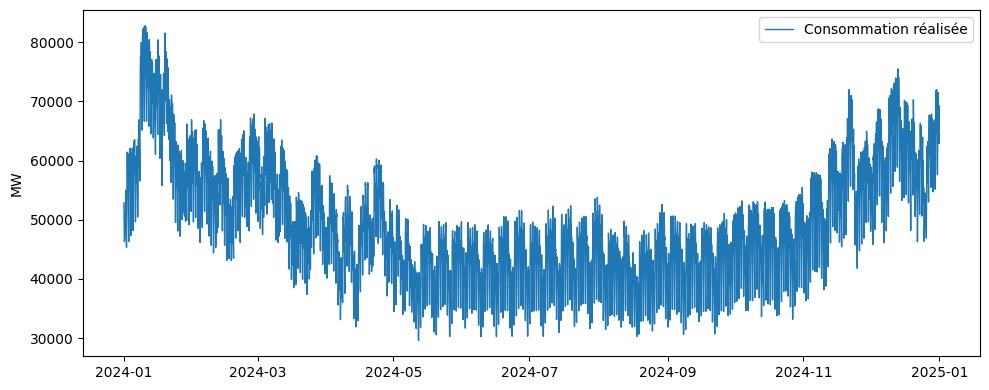

In [2]:

# Import des données
df = pd.read_csv("Consommation_France_2024.csv",index_col=0)
df["heure"] = pd.to_datetime(df["heure"])


# Visualisation de l'évolution annuelle de la consommation réalisée

fig, ax = plt.subplots(tight_layout=True,figsize =(10,4))

ax.plot(df["heure"],df["Consommation réalisée (MW)"],
        lw=1,
        label="Consommation réalisée")


ax.legend(loc="best")
ax.tick_params(axis="x", labelrotation=0)
ax.set_ylabel("MW")


Pour la suite, nous allons sélectionner une semaine pour réduire la taille du problème.

Au passage, nous pouvons mieux voir les variations régulières de la consommation à l'échelle de la semaine, notamment les cycles jour/nuit, les creux d'après midi, la différence jours ouvrés/week-end.


👉 **N'hésitez pas à changer `heure_debut` et `heure_fin` pour visualiser différentes semaine.**

Text(0, 0.5, 'MW')

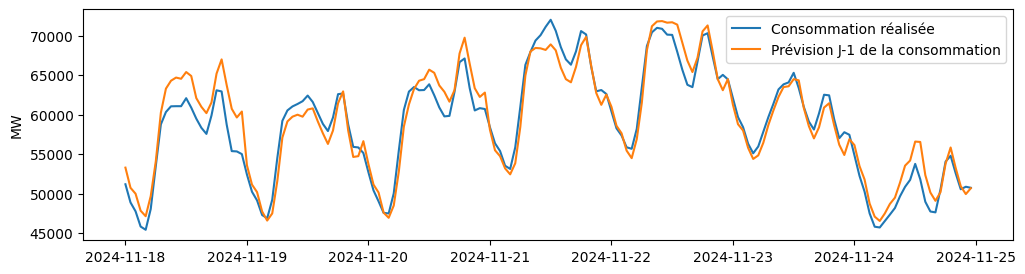

In [3]:
# Sélection de la semaine

heure_debut = pd.to_datetime("2024-11-18 00:00:00")
heure_fin = pd.to_datetime("2024-11-24 23:00:00")

semaine_example = df[df["heure"].between(heure_debut, heure_fin)]

# Traçage du graphique

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(semaine_example["heure"],
        semaine_example["Consommation réalisée (MW)"],
        label="Consommation réalisée")

ax.plot(semaine_example["heure"],
        semaine_example["Prévision J-1 de la consommation (MW)"],
        label = "Prévision J-1 de la consommation")

ax.legend(loc="best")
ax.set_ylabel("MW")

# Écriture et résolution du problème d'optimisation

## Formulation du problème

### Notations

#### Ensembles :

- $\mathcal{F}$ : ensemble des filières de production  
- $\mathcal{T}$ : ensemble des pas de temps


#### Paramètres :

- $\text{CV}_i$ : coût variable de la filière $i$ (€/MWh)  
- $\overline{P}_i$ : capacité maximale de la filière $i$ (MW)  
- $d_t$ : demande au pas de temps $t$ (MW)  
- $\text{VOLL}$ : coût de l’énergie non distribuée (€/MWh)


#### Variables de décision :

- $p_{i,t}$ : production de la filière $i$ au pas de temps $t$ (MW)  
- $\text{END}_t$ : énergie non distribuée au pas de temps $t$ (MW)


### Problème d'optimisation

#### Fonction objectif :
$$
\min_{p_{i,t}, \; \text{END}_t }  \;
\sum_{t \in \mathcal{T}} \sum_{i \in \mathcal{F}} \text{CV}_i \cdot p_{i,t}
\;+\;
\sum_{t \in \mathcal{T}}  \text{VOLL} \cdot \text{END}_t
$$


#### Contraintes :


Équilibre offre = demande :

$$
\forall t \in \mathcal{T}, \qquad
\sum_{i \in \mathcal{F}} p_{i,t} + \text{END}_t = d_t
$$


Contrainte de capacité :

$$
\forall i \in \mathcal{F}, \; \forall t \in \mathcal{T}, \qquad
p_{i,t} \le \overline{P}_i
$$


Positivité des variables de décision :

$$
\forall i \in \mathcal{F}, \; \forall t \in \mathcal{T}, \qquad
p_{i,t} \ge 0
$$

$$
\forall t \in \mathcal{T}, \qquad
\text{END}_t \ge 0.
$$


## Implémentation du problème

Nous allons écrire le problème court terme avec le package [PuLP](https://coin-or.github.io/pulp/).

Les différentes étapes sont :
1.   Déclarer les paramètres
2.   Initialiser un problème d'optimisation (qui sera vide au début)
3.   Déclarer les variables de décision (noms, ensembles de définitions, indices, etc.)
4.   Ecrire la fonction objectif
5.   Ecrire les contraintes



### Paramètres

Les différentes filières de production sont définies dans le dictionnaire `donnees_filieres`.  
Pour chaque filière $i$, on précise :
- son **coût variable** $\text{CV}_i$ (€/MWh),
- sa **capacité maximale** $\overline{P}_i$ (MW).

La demande utilisée dans le modèle correspond aux valeurs comprises entre `heure_debut` et `heure_fin` définies dans la cellule précédente.

Le paramètre `VOLL` représente le **coût de l’énergie non distribuée** (Value of Lost Load), exprimé en €/MWh.

👉 *N’hésitez pas à modifier les paramètres (coûts variables, capacités, ajout/suppression de filières, valeur de `VOLL`, etc.) pour tester différentes configurations !*


In [4]:
# Description des filières de production : coût variable et capacité maximale (MW)

donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "capacite": 52000.0},
    "hydraulique": {"cout_variable": 70.0,
                        "capacite": 6000.0},
    "gaz": {"cout_variable": 80.0,
              "capacite": 5000.0},
    "imports" : {"cout_variable": 100.0,
              "capacite": 10000.0},
}

# Demande (MW) à chaque pas de temps

demande = semaine_example["Consommation réalisée (MW)"].values

# Coût de l'énergie non distribuée (Value of Lost Load)
VOLL = 33000.0  # €/MWh


## Écriture du modèle
### Initialisation

Dans cette cellule, on définit :
- l'ensemble des filières $\mathcal{F}$ (à partir du dictionnaire `donnees_filieres`),
- l'ensemble des pas de temps $\mathcal{T}$ (une valeur par heure de la demande),
- puis on initialise un modèle d'optimisation `modele` que l'on remplira ensuite.

⚠️ **À exécuter sans modifier le contenu.** ⚠️


In [5]:
# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)

### Variables de décision

Dans cette cellule, nous créons les variables d’optimisation du modèle :

- $p_{i,t}$ : production de la filière $i$ au pas de temps $t$ (MW), stockée dans `prod[i][t]`.  
  Ces variables sont contraintes à être positives.

- $\text{END}_t$ : énergie non distribuée au pas de temps $t$ (MW), stockée dans `END[t]`.  
  Elle représente la part éventuelle de la demande non satisfaite et est également positive.




In [6]:
# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)


### Fonction objectif

Dans cette cellule, nous définissons la fonction objectif du problème.  
Elle correspond à la **minimisation du coût total** du système électrique :

- d’une part, le **coût de production** des différentes filières  
  (somme, pour chaque filière $i$ et chaque pas de temps $t$, de $CV_i \cdot p_{i,t}$),

- d’autre part, le **coût de l’énergie non distribuée**  
  (somme, pour chaque pas de temps $t$, de $\text{VOLL} \cdot \text{END}_t$).

L’objectif du modèle est donc de choisir les productions $p_{i,t}$ et l’énergie non distribuée $\text{END}_t$ de façon à **minimiser ce coût total**.


In [7]:
# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)

# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# Objectif total = production + END
modele += cout_production + cout_END



### Définition des contrainte

#### Contraintes d’équilibre offre = demande

Cette cellule implémente la contrainte d'équilibre offre=demande :

$$
\forall t \in \mathcal{T}, \qquad  \sum_{i \in \mathcal{F}} p_{i,t} + \text{END}_t = d_t
$$


In [8]:
for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )



Cette cellule implémente les contraintes de production :

$$
\forall i \in \mathcal{F}, \; \forall t \in \mathcal{T}, \qquad
p_{i,t} \le \overline{P}_i
$$

In [9]:
for i in filieres:
    cap = donnees_filieres[i]["capacite"]
    for t in T:
        modele += (
            prod[i][t] <= cap,
            f"Capacite_{i}_t{t}"
        )

### Résolution et affichage des résultats

### Résolution et lecture des résultats

Dans cette cellule, nous demandons au solveur d'optimiser le modèle.  
Une fois la résolution effectuée, nous affichons :
- le **statut** du problème (Optimal, Infeasible, etc.),
- le **coût total** obtenu,
- le détail du coût :
  - part liée à la production,
  - part liée à l'énergie non distribuée (END).

Nous construisons ensuite un `DataFrame` contenant, pour chaque pas de temps :
- la demande,
- l'END éventuelle,
- le prix marginal (shadow price de la contrainte d'équilibre),
- et la production de chaque filière.



In [13]:
# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'END :", pl.value(cout_END))

# ---- Affichage des résultats ----

df_resultats = pd.DataFrame({
    "heure": semaine_example["heure"].iloc[list(T)].values,
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


Statut : Optimal
Coût total : 183446060.0
	 dont coût de production : 183446060.0
	 dont coût de l'END : 0.0


Text(0.5, 1.0, 'Prix marginal horaire')

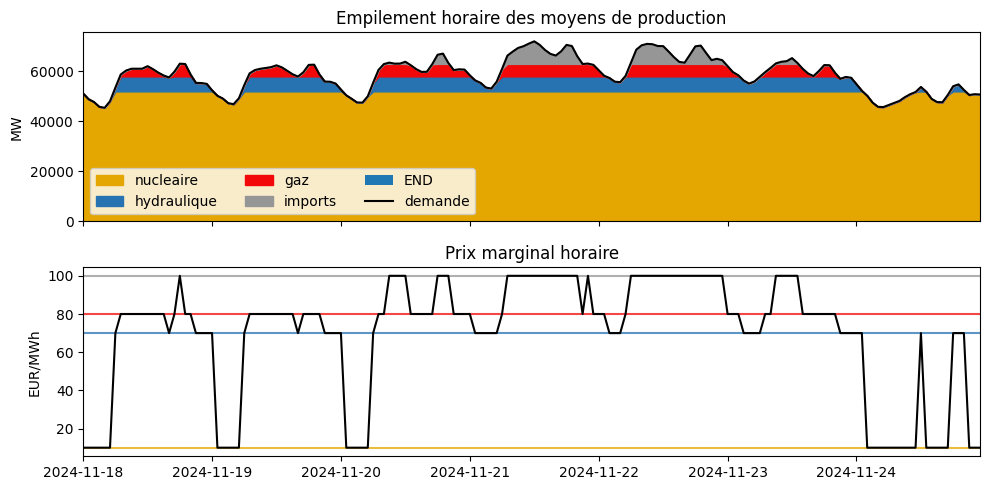

In [14]:
fig, axs = plt.subplots(figsize=(10,5),
                        nrows = 2,
                        sharex=True,
                        tight_layout=True)

# Premier graphique : équilibre offre=demande horaire

ax =  axs[0]

bottom = [0 for t in T]

for i in filieres :
  ax.fill_between(x = df_resultats["heure"],
                  y1 = bottom,
                  y2 = bottom + df_resultats["prod_"+i],
                  label=i,
                  color = config.couleurs[i])

  bottom += df_resultats["prod_"+i]

ax.fill_between(x=df_resultats["heure"],
                y1 = bottom,
                y2 = bottom + df_resultats["END"],
                label = "END")


ax.plot(df_resultats["heure"],
        df_resultats["demande"],
        color = "black",
        label = "demande")

ax.legend(loc="lower left",
          ncols=3)

ax.set_ylim([0,None])
ax.set_xlim([heure_debut,heure_fin])
ax.set_ylabel("MW")
ax.set_title("Empilement horaire des moyens de production")

ax = axs[1]

for i in filieres :
  ax.plot(df_resultats["heure"],
          [donnees_filieres[i]["cout_variable"] for t in T],
          color = config.couleurs[i],
          alpha=.75)


ax.plot(df_resultats["heure"],
        df_resultats["prix_marginal"],
        color="black")


ax.set_ylabel("EUR/MWh")
ax.set_title("Prix marginal horaire")

